# Lab Six: Convolutional Network Architectures

#### Machine Learning in Python
    
Will Lacey - 45906124 - <strong>CSE7324</strong>
<br>
Roger Wong - 43867412 - <strong>CSE5324</strong>

## ASL Alphabet
#### Image data set for alphabets in the American Sign Language

<img src='NIDCD-ASL-hands-2014.jpg' width="250">

For this lab, we again selected the American Sign Language Dataset. This time around, we plan to use the entire dataset, which is made up of 29 classes, each with a total of 3000 images. The ASL dataset includes the alphabet and three additional classes (del, space, and nothing).

Now that we understand better image processing techniques, we hope to accomplish a higher accuracy than we did before.

#### Import Modules and Initialization

Before we begin, let's import essential packages for data analysis

In [37]:
import keras
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average, concatenate
from keras.models import Input, Model
from keras.layers import SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Add
from keras.models import Sequential

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

from PIL import Image

import random
from random import randint

import seaborn as sns
sns.set(style='darkgrid')

import skimage.transform
# from skimage.io import imshow

import sklearn
import sklearn.datasets
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc, accuracy_score

import sys

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

## Preparation (30 points total)

Okay. First, let's declare a function to load, transform, and normalize images from the <strong>asl_alphabet</strong> dataset. Because we are loading our data with PIL, our images will be normalized upon loading.

In [2]:
def load_images(asl_classes, count, size):
    img_list = []
    for class_name in asl_classes:
        for i in range(count):
            img_path_string = 'asl_alphabet/'+class_name+'/'+class_name+str(i+1)+'.jpg'
            img = np.asarray(Image.open(img_path_string))
            img = skimage.transform.resize(img, (size, size), mode='constant') # resizes image
            img_list.append(img)
        sys.stderr.write('\rClass %s done' % class_name)
        sys.stderr.flush()
    return img_list

Now that our function is defined, we can go grab the images. This takes a few minutes.

In [3]:
%%time

number_of_images = 3000

img_size = 32

asl_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
               'del', 'space', 'nothing'
]

data_list = load_images(asl_classes, number_of_images, img_size)

Class nothing done

CPU times: user 3min 44s, sys: 19.8 s, total: 4min 4s
Wall time: 4min 48s


Here, we capture the class titles for each image and additionally convert them to numeric values. This will be useful later on for encoding our images in the neural networks and classifying them.

In [4]:
# Gather Class Titles
data_class = []
for i in range(len(asl_classes)):
    for j in range(number_of_images):
        data_class.append(asl_classes[i])
        
# Convert Class Titles to Values
data_value = []
for i in range(len(data_class)):
    data_value.append(asl_classes.index(data_class[i]))

Pause. Let's take a quick look at our different classes using our <strong>plot_gallery</strong> function from Lab2.

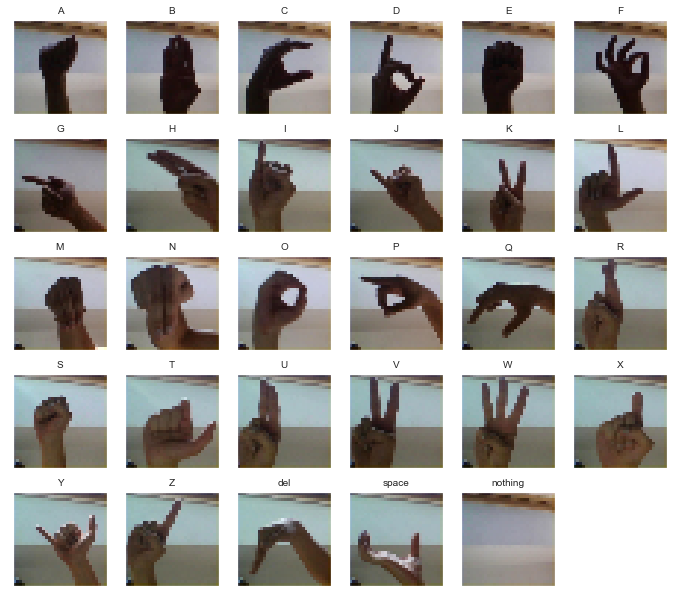

In [5]:
# a similar plotting function as seen in class; selects images from dataset
def plot_gallery(images, titles, class_count=29, random=False, n_row=5, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.9, top=.70, hspace=.1)
    for i in range(n_row * n_col):
        if i != (n_row * n_col - 1):
            plt.subplot(n_row, n_col, i + 1)
            if random:
                index = randint(1, len(images)-1)
            else:
                index =int(i * len(images) / class_count)
            plt.imshow(images[index])
            plt.title(titles[index], size=10)
            plt.xticks(())
            plt.yticks(())

        
plot_gallery(images=data_list, titles=data_class) 

In observing our different hand signs, we notice that several of the classes are similar. Most notably, we see that the similarity between A, E, and S, as well as M and N make the classes difficult to differentiate. Additionally, classes R, U and X along with G and H are not the easiest to decipher as well. Ideally, our classifier will be able to pick up these minute details and deliver a confident accuracy.

<em> 
<strong> [15 points] </strong>Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
</em>

For our dataset, the evaluation metric we selected was an accuracy score. While it is true that accuracy is rarely the best evaluation metric to use, we believed it would be the best for our dataset because of a few reasons. First, the American Sign Language alphabet would be normally used for spelling words or names in the midst of a conversation. Although the English language does not use each letter in the alphabet equally, the impetus for using the ASL alphabet would most likely be to spell a name or a unique word, which would follow a different trend than the distribution of the alphabet seen normally throughout the English dictionary and vernacular. In this vein, we really wouldn’t have favoritism over any particular letter or class, and as a result we would then have the luxury to care about each equally. In conjunction with this point, we also have an equal number of each class, which allows us to ignore any special weighting of our evaluation methods. In conclusion, we believe that this gives us the ability to use accuracy score to weigh and measure our algorithms. Through utilizing both an accuracy score and a confusion matrix, we will be able to compare and analyze our networks. 


<em> 
<strong>[15 points]</strong> Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 
</em>


In short, for our cross validation method we are simply shuffling our data and then performing an 80/20 split on it. 

As mentioned before, our dataset has a total of 29 different classes. For every class, the dataset has subdirectory where each subdirectory includes a corresponding set of images that appear to have been stripped from a video. This seems to be the case because each image, labeled 1 to 3000, seems to be highly similar to its numeric neighbor.  For a quick example, image 1000 is very similar in appearance to image 999 and 1001 but less similar to image 1 or 3000. To prevent the model from both seeing very similar, almost duplicate, images and from learning that adjacent images are most likely the same class, we randomly shuffled the data. This makes the input more realistically trainable. 

We decided to do an 80/20 split on our data because after the split we still have 2400 trainable images per class, totaling a sum of 69600 images for the trainable portion of the dataset. This amount of data, we believe, is sufficient to split since it should still capture how our model will perform in actuality. While in deployment the model should train on even more images to raise the accuracy further, the amount we currently have will absolutely suffice in capturing a lower bound of its performance. 


Alright, let's continue preparing the data. Next we'll make our corresponding shuffle and split functions.

In [6]:
def shuffle(data, seed=0):
    """Shuffles the data given a random seed"""
    random.seed(seed)
    random.shuffle(data)
    return data

def split(data, number_of_classes, percentage):
    """Splits data and target into training and testing data based off the split percentage"""

    train = []
    test = []
    number_per_class = int(len(data) / number_of_classes)
    
    for i in range(number_of_classes):
        start = i * number_per_class
        index_split = start + int(percentage * number_per_class)
        end = (i * number_per_class) + number_per_class
        
        train.extend(data[start:index_split])
        test.extend(data[index_split:end])
        
    return train, test

In the next few cells, we are going to create a <strong>sklearn Bunch</strong> object to better organize our data. The object will split the <em>image data</em> along with both the <em>class titles</em> and the <em>encoded class titles</em> of the dataset into <strong>X_train</strong>, <strong>y_train (either class or value)</strong>, <strong>X_test</strong>, and <strong>y_test (either class or value)</strong> numpy arrays. We will also add <strong>y_train_ohe</strong> and <strong>y_test_ohe</strong> to keep track of the one hot encoding of the <em>encoded class titles</em>. In addition, the object will have the numpy array, <strong>y_classes</strong>, as a container for all the various classes of the dataset and, lastly, <strong>img_size</strong>, to keep track of the image dimensions. 

These variables will contain the essential data needed to perform data analysis and training for our neural networks. In further detail, here's a description of each variable within our <strong>sklearn Bunch</strong> object.

##### Training
<ul>
    <li><strong>X_train</strong> - The ASL image training dataset; 2D numpy vectors that have been transformed into <strong>img_size</strong> number of pixels</li>
    <li><strong>y_train_class</strong> - The ASL image training dataset associated class names; each instance is a class name which can be mapped to the corresponding image 2D vector by index</li>
    <li><strong>y_train_value</strong> - The ASL image training dataset associated class values; each instance is a class value which can be mapped to the corresponding image 2D vector and target class by index</li>
    <li><strong>y_train_ohe</strong> - A one-hot-encoding of the <strong>y_train_value</strong> data member</li>
</ul>

##### Testing
<ul>
    <li><strong>X_test</strong> - The ASL image testing dataset; 2D numpy vectors that have been transformed into <strong>img_size</strong> number of pixels</li>
    <li><strong>y_test_class</strong> - The ASL image testing dataset associated class names; each instance is a class name which can be mapped to the corresponding image 2D vector by index</li>
    <li><strong>y_test_value</strong> - The ASL image testing dataset associated class values; each instance is a class value which can be mapped to the corresponding image 2D vector and target class by index</li>
    <li><strong>y_test_ohe</strong> - A one-hot-encoding of the <strong>y_test_value</strong> data member</li>
</ul>

##### Additional Variables
<ul>
    <li><strong>y_classes</strong> - A numpy array of class names present in the ASL image dataset; contains the alphabet and three additional classes</li>
    <li><strong>img_size</strong> - The side dimension (length and width are equal) of each image or 2D vector within the ASL image training dataset</li>
</ul>

This next cell calls our <strong>shuffle</strong> and <strong>split</strong> functions on our data, and creates the <strong>sklearn Bunch</strong> object

In [7]:
# Shuffle Data
random_seed = randint(0, 1000) # Create a random seed for shuffling
data_list = shuffle(data_list, random_seed)
data_class = shuffle(data_class, random_seed)
data_value = shuffle(data_value, random_seed)

# Split Data
percentage = 4/5 # 80, 20 split
data_list_train, data_list_test = split(data_list, len(asl_classes), percentage)
data_class_train, data_class_test = split(data_class, len(asl_classes), percentage)
data_value_train, data_value_test = split(data_value, len(asl_classes), percentage)

# Create sklearn Bunch Object
ds = sklearn.datasets.base.Bunch(
    
    # Load in image data (samples, length, width, channels)
    X_train = np.array(data_list_train),
    
    # Dividing y_train into class names, encoded values (from 0 to 28), and one-hot-encoding
    y_train_class = np.array(data_class_train),
    y_train_value = np.array(data_value_train),
    y_train_ohe = keras.utils.to_categorical(data_value_train, len(asl_classes)),

    # Load in image data (samples, length, width, channels)
    X_test = np.array(data_list_test),
    
    # Dividing y_test into class names, encoded values (from 0 to 28), and one-hot-encoding
    y_test_class = np.array(data_class_test),
    y_test_value = np.array(data_value_test),
    y_test_ohe = keras.utils.to_categorical(data_value_test, len(asl_classes)),
    
    # The Various Class Titles
    y_classes = np.array(asl_classes),
    
    # Length and Width of Images
    img_size = img_size
)

# Printing Dimensions of Object
print('Shape of X_train:', ds.X_train.shape)
print('Shape of y_train \'class\' and \'value\':', ds.y_train_class.shape)
print('Shape of y_train_ohe:', ds.y_train_ohe.shape)
print('Shape of X_test:', ds.X_test.shape)
print('Shape of y_train \'class\' and \'value\':', ds.y_test_value.shape)
print('Shape of y_test_ohe:', ds.y_test_ohe.shape)
print('Shape of y_classes:', ds.y_classes.shape)
print('Length/Width of images:', ds.img_size)

Shape of X_train: (69600, 32, 32, 3)
Shape of y_train 'class' and 'value': (69600,)
Shape of y_train_ohe: (69600, 29)
Shape of X_test: (17400, 32, 32, 3)
Shape of y_train 'class' and 'value': (17400,)
Shape of y_test_ohe: (17400, 29)
Shape of y_classes: (29,)
Length/Width of images: 32


Now that we have stored all our data inside of the object, we are going to delete the previously used data structures that we no longer need. 

In [8]:
del data_list
del data_class_train
del data_class_test
del data_class
del data_value
del data_value_train
del data_value_test
del asl_classes
del img_size

Alright, let's take another look at the images. Now that they're shuffled and split, the images should take a seemingly random order.

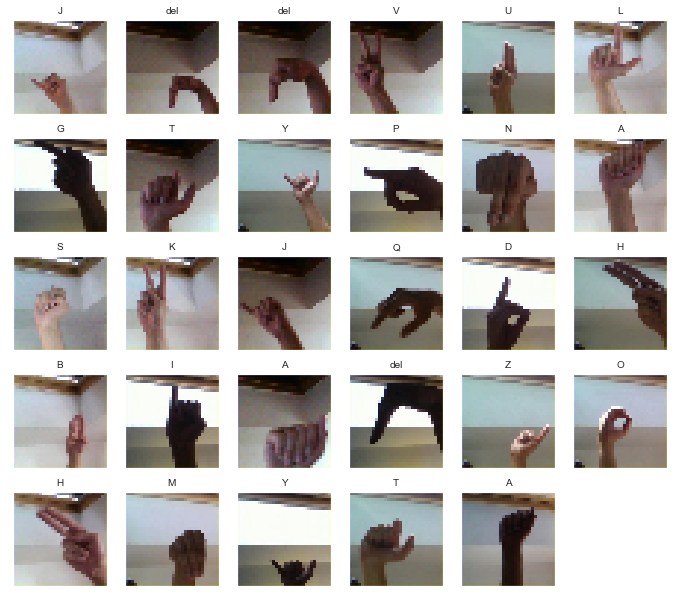

In [9]:
plot_gallery(images=ds.X_train, titles=ds.y_train_class) 

## Modeling (60 points total)

Before we begin modeling, let's create a few functions to fit, predict, track, and analyze our neural networks.

In [10]:
def network_fit(nn, datagen, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, patience=4, verbose=0):
    """Fits data to a neural network using a specified epoch count and batch size; also 
    utilizes a specified data expansion"""
    history = nn.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                               steps_per_epoch=int(len(X_train)/batch_size),
                               epochs=epochs, 
                               verbose=verbose, 
                               validation_data = (X_test, y_test),
                               callbacks=[EarlyStopping(monitor='val_loss', patience=patience)]
    )
    
    return history

def network_predict(nn, X_test, y_test):
    """Returns an accuracy for a neural network, a confusion matrix, and ROC data"""
    yhat_proba = nn.predict(X_test)
    yhat = np.round(yhat_proba)
    acc = mt.accuracy_score(y_test, yhat)
    fpr, tpr, _ = roc_curve(y_test.flatten(), yhat_proba.flatten())
    roc_auc = auc(fpr, tpr)
    return acc, fpr, tpr, roc_auc

def network_plot(history):    
    """Visualizes the performance of the training and validation sets per epoch"""
    plt.figure(figsize=(15,5))

    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

def network_summarize(net, X_test, y_test, title_text=''):
    """This function is similar to the one seen in class; visualizes the confusion matrix"""
    plt.figure(figsize=(15,10))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

Let's also create a couple variables for training. These parameters will be more or less the guidelines for our networks.

In [11]:
epochs = 300
batch_size = 128
patience = 5
verbose = 1

<em> 
    <strong>[15 points]</strong> Create a convolutional neural network to use on your data using Keras. Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 
</em>

In this cell, we implement data expansion through Keras's ImageDataGenerator as seen in lecture. We utilized a 10% width and height shift in our images along with a 5º rotational transform. These parameters we copied from class because we saw them fit for our dataset and images. These mutations allow for change in the images without losing the integrity of the class. Any shift or rotation larger than these thresholds threaten losing essential information in the images.

In [12]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(ds.X_train)

For our first convolutional neural network, we created an architecture where we utilized a 2 by 2 convolutional filter and maxpool. The entire architecture consists of three convolutional layers and then a fully connected multilayer perceptron with three dense layers. At every activation except for the final layer, we implement ReLu to handle vanishing gradients. Let's see how it does.

In [13]:
num_filt_layers = [32,64,64]

inputs = Input(shape=ds.X_test[0].shape, name='Input')
x = inputs
for num_filt in num_filt_layers:
    x = Conv2D(filters=num_filt,
               kernel_size=(2,2),
               padding='same', 
               input_shape=ds.X_test[0].shape,
               data_format="channels_last")(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(len(ds.y_classes), activation='softmax')(x) 

cnn = Model(inputs=inputs, outputs=predictions)

cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

Above is a print out of our <strong>CNN</strong>'s architecture. Now that our model has been built, we can pass our network on to our <strong>network_fit</strong> function to train our model on our training data.

In [14]:
%%time

history = network_fit(cnn, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      patience=patience, 
                      verbose=verbose
)

Epoch 1/300
543/543 [==============================] - 51s 94ms/step - loss: 0.0282 - acc: 0.2723 - val_loss: 0.0205 - val_acc: 0.5236
Epoch 2/300
543/543 [==============================] - 53s 97ms/step - loss: 0.0189 - acc: 0.5621 - val_loss: 0.0138 - val_acc: 0.6967
Epoch 3/300
543/543 [==============================] - 52s 95ms/step - loss: 0.0136 - acc: 0.6985 - val_loss: 0.0105 - val_acc: 0.7703
Epoch 4/300
543/543 [==============================] - 52s 96ms/step - loss: 0.0102 - acc: 0.7833 - val_loss: 0.0066 - val_acc: 0.8634
Epoch 5/300
543/543 [==============================] - 53s 97ms/step - loss: 0.0078 - acc: 0.8387 - val_loss: 0.0051 - val_acc: 0.8974
Epoch 6/300
543/543 [==============================] - 53s 97ms/step - loss: 0.0061 - acc: 0.8754 - val_loss: 0.0047 - val_acc: 0.9044
Epoch 7/300
543/543 [==============================] - 55s 101ms/step - loss: 0.0049 - acc: 0.9018 - val_loss: 0.0053 - val_acc: 0.8936
Epoch 8/300
543/543 [==============================] -

After running for about an hour, we were able to achieve a validation accuracy greater than 99%. Let's visualize how our model converged using <strong>network_plot</strong>.

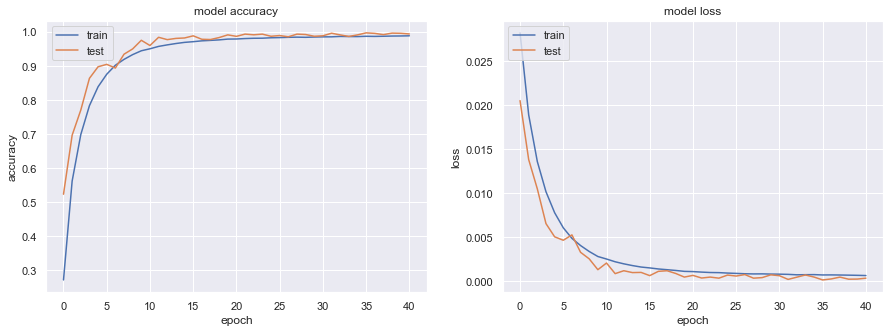

In [15]:
network_plot(history)

Let's train again with the same model, except this time, let's change the batch size to 16. First, we rebuild the model to clear the weights. Afterwards, we immediately train.

In [16]:
%%time

num_filt_layers = [32,64,64]

inputs = Input(shape=ds.X_test[0].shape, name='Input')
x = inputs
for num_filt in num_filt_layers:
    x = Conv2D(filters=num_filt,
               kernel_size=(2,2),
               padding='same', 
               input_shape=ds.X_test[0].shape,
               data_format="channels_last")(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(len(ds.y_classes), activation='softmax')(x) 

cnn = Model(inputs=inputs, outputs=predictions)

cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = network_fit(cnn, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs=epochs, 
                      batch_size=16, 
                      patience=patience, 
                      verbose=verbose
)

Epoch 1/300
4350/4350 [==============================] - 70s 16ms/step - loss: 0.0210 - acc: 0.4834 - val_loss: 0.0106 - val_acc: 0.7680
Epoch 2/300
4350/4350 [==============================] - 68s 16ms/step - loss: 0.0091 - acc: 0.8054 - val_loss: 0.0053 - val_acc: 0.8898
Epoch 3/300
4350/4350 [==============================] - 67s 15ms/step - loss: 0.0057 - acc: 0.8836 - val_loss: 0.0051 - val_acc: 0.8997
Epoch 4/300
4350/4350 [==============================] - 67s 15ms/step - loss: 0.0043 - acc: 0.9151 - val_loss: 0.0017 - val_acc: 0.9660
Epoch 5/300
4350/4350 [==============================] - 66s 15ms/step - loss: 0.0036 - acc: 0.9298 - val_loss: 0.0024 - val_acc: 0.9534
Epoch 6/300
4350/4350 [==============================] - 67s 15ms/step - loss: 0.0031 - acc: 0.9399 - val_loss: 0.0016 - val_acc: 0.9694
Epoch 7/300
4350/4350 [==============================] - 64s 15ms/step - loss: 0.0030 - acc: 0.9435 - val_loss: 0.0017 - val_acc: 0.9683
Epoch 8/300
4350/4350 [==================

Changing the batch size to a smaller value for this network ultimately made the network converge much faster. While the model ran for only a fraction of the time as it did previously, it's unclear whether the model reached its global optimum. Considering it terminated after only 14 epochs and yielded a lower accuracy, we believe that the model's <strong>patience</strong>, for early stopping, was set too low. In the next cell, we again visualize the convergence of our network.

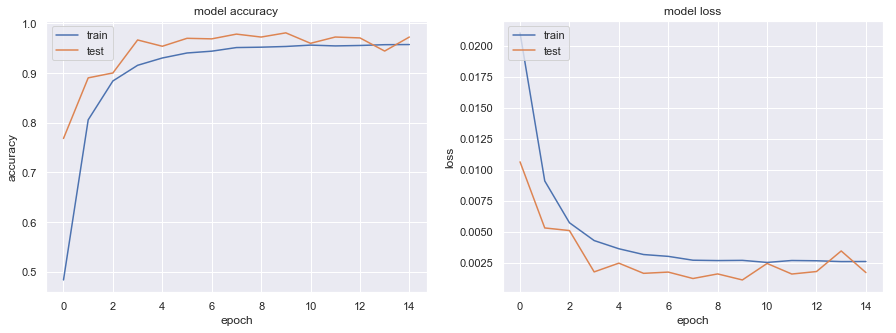

In [17]:
network_plot(history)

<em> 
    <strong>[20 points]</strong> Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).
</em>


For our second architecture we decided to use the Xception styled model that we implemented in class. We decided to test this model on our dataset because of its success on the Fashion MNIST dataset.

In [18]:
# Xception style architecture

l2_lambda = 0.000001
shape = ds.X_train[0].shape

input_holder = Input(shape=shape)

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


# x = Activation("relu")(x_split)

# x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x_split)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(len(ds.y_classes),activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 32)   9248        max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
max_poolin

Okay, after printing out a summary of Xception, let's train the model with <strong>network_fit</strong> again.

In [19]:
%%time

history = network_fit(xception, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      patience=patience,
                      verbose=verbose
)

Epoch 1/300
543/543 [==============================] - 69s 127ms/step - loss: 2.4732 - acc: 0.2638 - val_loss: 1.3152 - val_acc: 0.5805
Epoch 2/300
543/543 [==============================] - 64s 118ms/step - loss: 1.3127 - acc: 0.5683 - val_loss: 0.6859 - val_acc: 0.7893
Epoch 3/300
543/543 [==============================] - 64s 118ms/step - loss: 0.9215 - acc: 0.6837 - val_loss: 0.4405 - val_acc: 0.8580
Epoch 4/300
543/543 [==============================] - 64s 118ms/step - loss: 0.7231 - acc: 0.7503 - val_loss: 0.3276 - val_acc: 0.9003
Epoch 5/300
543/543 [==============================] - 65s 120ms/step - loss: 0.5953 - acc: 0.7922 - val_loss: 0.2728 - val_acc: 0.9101
Epoch 6/300
543/543 [==============================] - 66s 122ms/step - loss: 0.5161 - acc: 0.8186 - val_loss: 0.2405 - val_acc: 0.9207
Epoch 7/300
543/543 [==============================] - 66s 122ms/step - loss: 0.4524 - acc: 0.8414 - val_loss: 0.1521 - val_acc: 0.9550
Epoch 8/300
543/543 [===========================

We trained our Xception model for an hour, achieving an accuracy greater than 99% again.

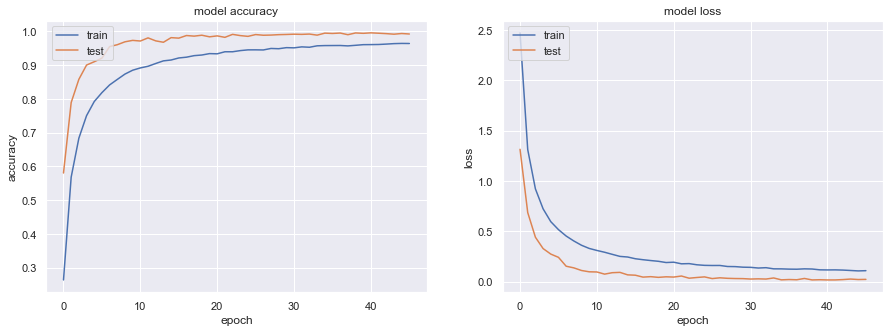

In [20]:
network_plot(history)

So far, it's hard to say whether our <strong>CNN</strong> or our <strong>Xception-style CNN</strong> performed better. Truthfully, both of these models converge to an accuracy that would be suitable for deployment. Before we move on, we're going to run Xception one more time with a smaller batch size.

In [21]:
%%time

input_holder = Input(shape=shape)

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)


x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = SeparableConv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])

x = SeparableConv2D(filters=32,
               input_shape = shape,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               depth_multiplier = 1, # controls output channels
               data_format="channels_last")(x_split)


x_split = Add()([x, x_split])


# x = Activation("relu")(x_split)

# x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x_split)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(len(ds.y_classes),activation="softmax")(x)

xception = Model(inputs=input_holder,outputs=x)

xception.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

history = network_fit(xception, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs=epochs, 
                      batch_size=16, 
                      patience=patience,
                      verbose=verbose
)

Epoch 1/300
4350/4350 [==============================] - 79s 18ms/step - loss: 1.6952 - acc: 0.4712 - val_loss: 0.5604 - val_acc: 0.8250
Epoch 2/300
4350/4350 [==============================] - 79s 18ms/step - loss: 0.7514 - acc: 0.7407 - val_loss: 0.3143 - val_acc: 0.8930
Epoch 3/300
4350/4350 [==============================] - 82s 19ms/step - loss: 0.5480 - acc: 0.8115 - val_loss: 0.1962 - val_acc: 0.9361
Epoch 4/300
4350/4350 [==============================] - 81s 19ms/step - loss: 0.4485 - acc: 0.8455 - val_loss: 0.1501 - val_acc: 0.9519
Epoch 5/300
4350/4350 [==============================] - 81s 19ms/step - loss: 0.3877 - acc: 0.8663 - val_loss: 0.1234 - val_acc: 0.9609
Epoch 6/300
4350/4350 [==============================] - 81s 19ms/step - loss: 0.3483 - acc: 0.8813 - val_loss: 0.0981 - val_acc: 0.9690
Epoch 7/300
4350/4350 [==============================] - 83s 19ms/step - loss: 0.3250 - acc: 0.8892 - val_loss: 0.0830 - val_acc: 0.9756
Epoch 8/300
4350/4350 [==================

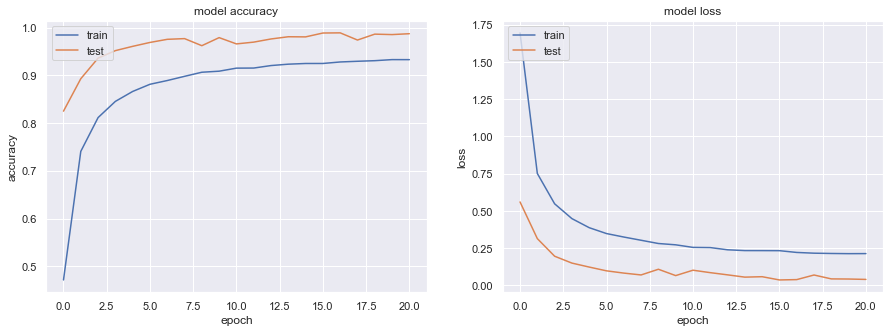

In [22]:
network_plot(history)

Again, we see a possible problem of early stopping in the model as it converged on an accuracy lower than we saw before. We can take away two things from this for the future. One is that we could increase the threshold of the patience so that it doesn't terminate too early. This would allow for the model to train longer and terminate when it is more likely asymptotically approaching a value. However, another idea could be to add dropout to the fully connected layers. This, ontop of data expansion, would really prevent the model from overfitting. Considering this, we could set the epoch value to be extrodinarily high to almost guarentee ourselves a global optimum by the end of computation. However, this would certainly take a few hours, in the least, to train. If a company was consdering our model, they would most likely want to train for this long to guarentee the highest performance.

<em> 
    <strong>[15 points] </strong>Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 
</em>

In the next few cells, we call <strong>network_predict</strong> and <strong>network_summarize</strong> on our networks. We recieve our model's accuracy and confusion matrix, and, additionally, we get the receiver operating characteristic data to later compare the model's directly.

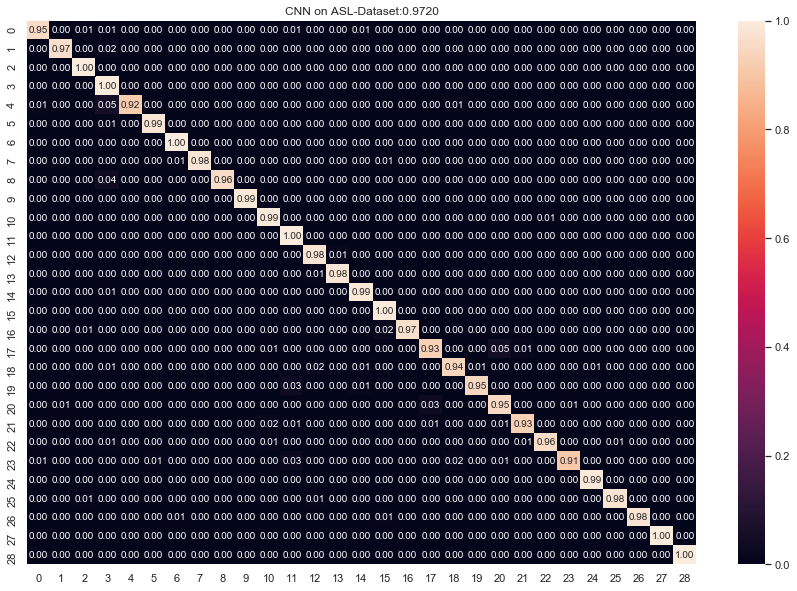

In [23]:
acc, fpr_cnn, tpr_cnn, roc_auc_cnn = network_predict(cnn, ds.X_test, ds.y_test_ohe)

network_summarize(cnn, ds.X_test, ds.y_test_value, title_text='CNN on ASL-Dataset:')

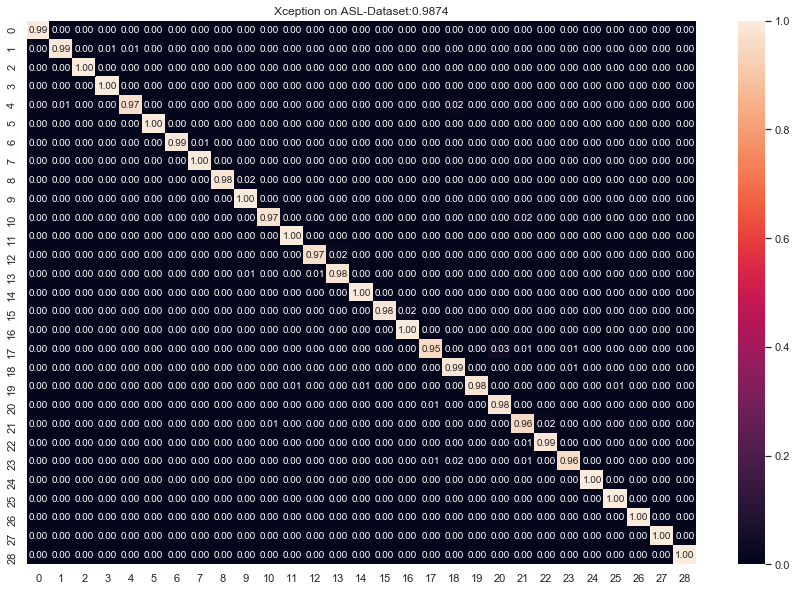

In [24]:
acc, fpr_xception, tpr_xception, roc_auc_xception = network_predict(xception, ds.X_test, ds.y_test_ohe)

network_summarize(xception, ds.X_test, ds.y_test_value, title_text='Xception on ASL-Dataset:')

It's a close call, but the <strong>Xception-style CNN</strong> actually outperforms our other <strong>CNN</strong> model. However, these graphs only consider the output of the training where our batch size was set to 16. Because of the accuracy we saw with the larger batch, we can say that the two models are effectively equivalent in performance.

<em> 
    <strong>[10 points]</strong> Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  
</em>

Okay! Time to compare out model's to an <strong>MLP</strong>. First, let's build a quick <strong>MLP</strong> framework.

In [25]:
shape = ds.X_train[0].shape

mlp = Sequential()
mlp.add( Reshape((ds.X_train[0].flatten().shape), input_shape=shape, name='Reshape') )
mlp.add( Dense(units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(len(ds.y_classes)) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               307300    
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 29)                1479      
_________________________________________________________________
activation_7 (Activation)    (None, 29)                0         
Total params: 313,829
Trainable params: 313,829
Non-trainable params: 0
_________________________________________________________________


Hmm. We've pretty much seen everything above before. The most notable mention is that the <strong>MLP</strong> reshapes the 2D input data into linearized numpy vectors. This is so the model can properly handle the images. 

Otherwise, you know the drill, let's go ahead and train our model.

In [26]:
%%time

history = network_fit(mlp, 
                      datagen, 
                      ds.X_train, 
                      ds.y_train_ohe, 
                      ds.X_test, 
                      ds.y_test_ohe, 
                      epochs = epochs, 
                      batch_size=16, 
                      patience=patience,
                      verbose=verbose
)

Epoch 1/300
4350/4350 [==============================] - 35s 8ms/step - loss: 0.0325 - acc: 0.1023 - val_loss: 0.0312 - val_acc: 0.1621
Epoch 2/300
4350/4350 [==============================] - 35s 8ms/step - loss: 0.0316 - acc: 0.1449 - val_loss: 0.0306 - val_acc: 0.1780
Epoch 3/300
4350/4350 [==============================] - 35s 8ms/step - loss: 0.0312 - acc: 0.1622 - val_loss: 0.0305 - val_acc: 0.1868
Epoch 4/300
4350/4350 [==============================] - 35s 8ms/step - loss: 0.0309 - acc: 0.1739 - val_loss: 0.0299 - val_acc: 0.2106
Epoch 5/300
4350/4350 [==============================] - 35s 8ms/step - loss: 0.0307 - acc: 0.1836 - val_loss: 0.0300 - val_acc: 0.2058
Epoch 6/300
4350/4350 [==============================] - 35s 8ms/step - loss: 0.0306 - acc: 0.1888 - val_loss: 0.0297 - val_acc: 0.2261
Epoch 7/300
4350/4350 [==============================] - 35s 8ms/step - loss: 0.0306 - acc: 0.1921 - val_loss: 0.0313 - val_acc: 0.1633
Epoch 8/300
4350/4350 [=========================

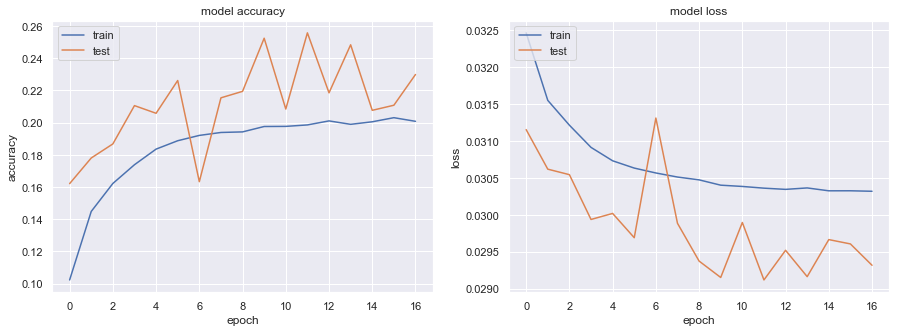

In [27]:
network_plot(history)

Dubious of the results, we actually trained the model again with the same parameters. Here is the accuracy per iteration that we got:

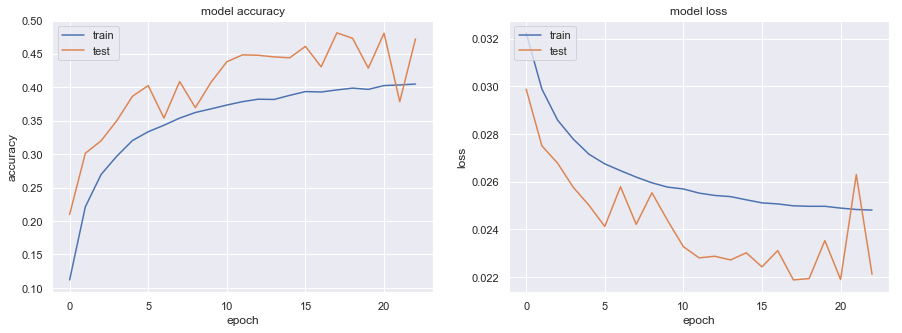

In [26]:
network_plot(history)

Wow, the accuracy of the <strong>MLP</strong> is almost doubled in the second epoch history graph. Again this suggests the possibility of under training. Since the <strong>MLP</strong> converged at two vastly different destinations in such a short window of time, we believe its safe to say the <strong>patience</strong> parameter we set prior to training was too strict.

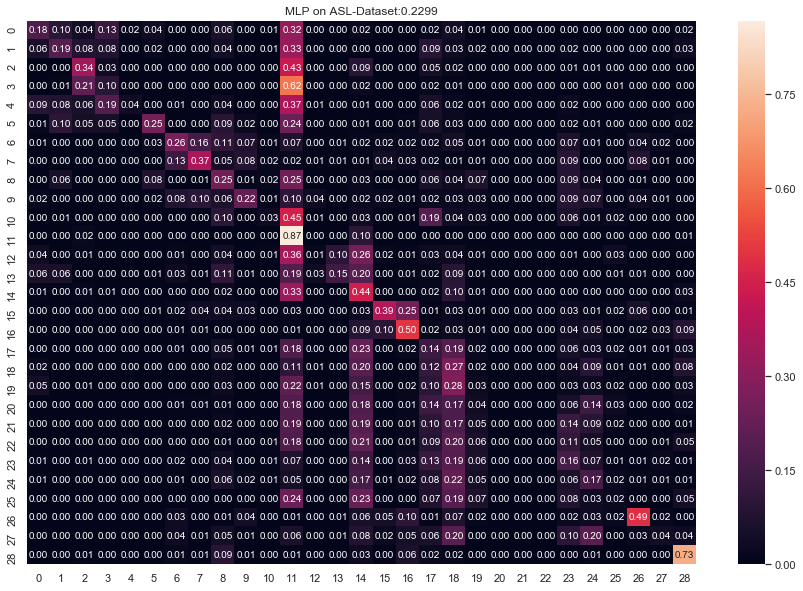

In [28]:
acc, fpr_mlp, tpr_mlp, roc_auc_mlp = network_predict(mlp, ds.X_test, ds.y_test_ohe)

network_summarize(mlp, ds.X_test, ds.y_test_value, title_text='MLP on ASL-Dataset:')

Not much to say here... Yikes. The undertrained <strong>MLP</strong> yields an abyssal accuracy for all classes, some worse than others.

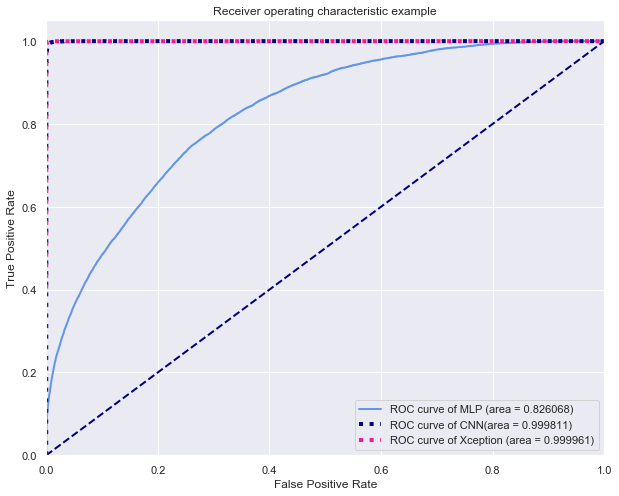

In [29]:
plt.figure(figsize=(10,8))
lw = 2

# MLP
plt.plot(fpr_mlp, tpr_mlp, color='cornflowerblue',
         lw=lw, label='ROC curve of MLP (area = %0.6f)' % roc_auc_mlp)

# CNN 1
plt.plot(fpr_cnn, tpr_cnn, color='navy', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of CNN(area = %0.6f)' % roc_auc_cnn)

# CNN 2
plt.plot(fpr_xception, tpr_xception, color='deeppink', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of Xception (area = %0.6f)' % roc_auc_xception)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Since classes are weighted equally across the board, micro ROC was a great way to capture the differences in the models. Additionally, since we have no preference over false positives or true negatives, the best way to rate the models is by taking the area under the curve, which is printed out in the bottom right-hand corner. As we concluded earlier, the winner of the <strong>CNN's</strong> is unclear however they certainly outperformed the <strong>MLP</strong>.

## Exceptional Work (10 points total)

<em> 
    <strong>[10 points]</strong>You have free reign to provide additional analyses. 
One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training from scratch in terms of classification performance.
</em>

For our pre-training weights we decided to import Xception.

In [30]:
%%time

from keras.applications import Xception
from keras.applications.xception import preprocess_input

# load only convolutional layers of Xception:
xception_no_top = Xception(weights='imagenet', include_top=False)

x_train_pre = preprocess_input(ds.X_train)
X_test_pre = preprocess_input(ds.X_test)

# train on half the data, to save a few hours
x_train_xception = xception_no_top.predict(x_train_pre)
x_test_xception = xception_no_top.predict(X_test_pre)

CPU times: user 42min 37s, sys: 2min 21s, total: 44min 59s
Wall time: 7min 12s


Taking a look, this is the shape of where the weights were cut off from Xception.

In [31]:
shape = x_train_xception[0].shape
print(shape)

(1, 1, 2048)


Okay. Let's take those weights and append a couple of dense layers to them forming a small neural network.

In [32]:
inputs = Input(shape=shape)
x = Flatten()(inputs)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
predictions = Dense(len(ds.y_classes), activation='softmax', kernel_initializer='glorot_uniform')(x)

pre = Model(inputs=inputs, outputs=predictions)

pre.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 200)               409800    
_________________________________________________________________
dense_15 (Dense)             (None, 29)                5829      
Total params: 415,629
Trainable params: 415,629
Non-trainable params: 0
_________________________________________________________________


Taking some wisdom from our previous models, we decided to amp up the number of <strong>epochs</strong> and increase the <strong>patience</strong> for training. With our new parameters, let's train the pre-trained network.

In [33]:
%%time

epochs = 3000
batch_size = 32
patience = 30
verbose = 0

y_train_ohe_xception = ds.y_train_ohe[:x_train_xception.shape[0]]

history = pre.fit(x_train_xception,
                    y_train_ohe_xception,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    validation_data=(x_test_xception, ds.y_test_ohe[:x_test_xception.shape[0]]),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=patience)]
)

CPU times: user 3h 19min 32s, sys: 30min 59s, total: 3h 50min 32s
Wall time: 1h 1min 15s


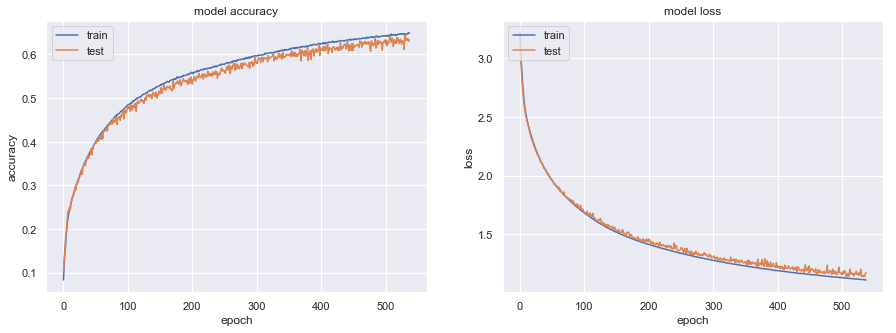

In [34]:
network_plot(history)

Dang, after 600 epochs and 30 iterations of stagnation in the loss value, we still wonder if the model actually converged. Regardless, this model is certainly insignificant to both our <strong>CNN</strong> and our <strong>Xception-styled CNN</strong> given its resulting accuracy after an hour of training.

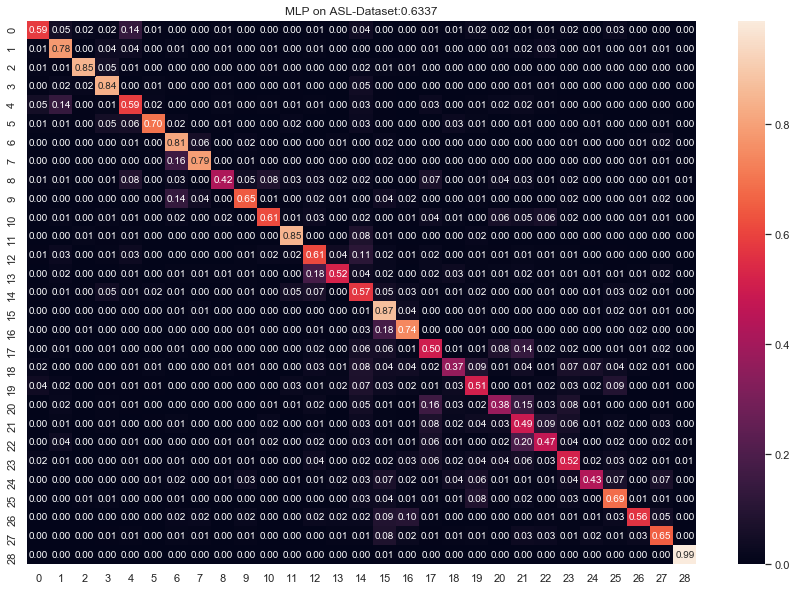

In [35]:
acc, fpr_pre, tpr_pre, roc_auc_pre = network_predict(pre, x_test_xception, ds.y_test_ohe[:x_test_xception.shape[0]])

network_summarize(pre, x_test_xception, ds.y_test_value, title_text='MLP on ASL-Dataset:')

Viewing the graph above, it's clear that the pre-trained weights in Xception were not helpful in classifying letters of the American Sign Language.

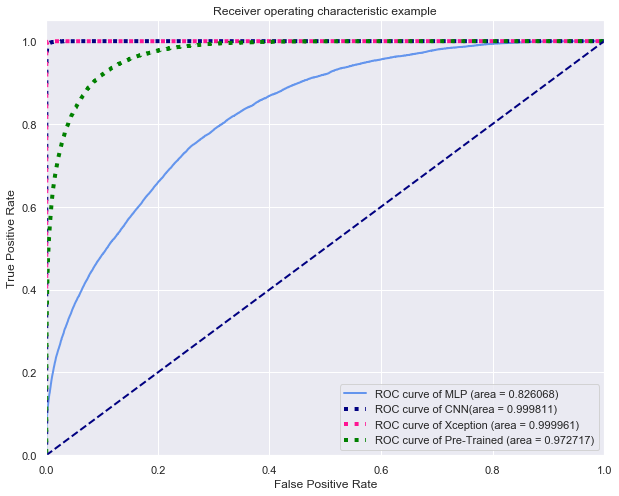

In [36]:
plt.figure(figsize=(10,8))
lw = 2

# MLP
plt.plot(fpr_mlp, tpr_mlp, color='cornflowerblue',
         lw=lw, label='ROC curve of MLP (area = %0.6f)' % roc_auc_mlp)

# CNN
plt.plot(fpr_cnn, tpr_cnn, color='navy', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of CNN(area = %0.6f)' % roc_auc_cnn)

# Xception
plt.plot(fpr_xception, tpr_xception, color='deeppink', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of Xception (area = %0.6f)' % roc_auc_xception)

# Pre-Trained
plt.plot(fpr_pre, tpr_pre, color='green', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of Pre-Trained (area = %0.6f)' % roc_auc_pre)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Viewing the area under the curve, it's clear that our CNN's performed better than the other models. For deployment, we would most likely select the <strong>Xception-styled CNN</strong> and train it for a longer period of time, letting the model asymptotically approach a value before terminating the training.